# Hate Speech Detector 2.0
---
**Simple Machine Learning text classifier**
1. Load data with duplicates (to prevent from error by stratification).
2. Lemmatize function, PAC calculation, other scores calculation. Load hateful phrases and topics.
3. Implement simple ML classifiers (i.e.: DecisionTree, SVM, RandomForest, etc.).
4. Research for various parameters in order to find the best classifier.
5. Visualize results.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import os
import csv
import pickle

import numpy as np
import pandas as pd

from skmultilearn.model_selection import IterativeStratification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from combo.predict import COMBO
import itertools

import pyphen
from polyglot.text import Text

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")

In [4]:
LABELS = ['wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie', 'poniżanie', 'stygmatyzacja', 'szantaż']
LABELS_SMALL = ['wyz', 'groz', 'wyk', 'odcz', 'pon', 'styg', 'szan']
SCORE_TYPES = ['min', 'mean', 'max']

HATEFUL_EXT_DIR = 'data/hateful/ext_{}.txt'
VULGARS_EXT_DIR = 'data/vulgars/ext_{}.txt'

DUPLICATED_PATH = 'data/tweets_sady/processed/sady_duplicated.csv'
POC_SCORES_PATH = 'data/tweets_sady/processed/poc_scores.csv'
TOPIC_POC_SCORES_PATH = 'data/tweets_sady/processed/topic_poc_scores.csv'
OTHER_SCORES_PATH = 'data/tweets_sady/processed/other_scores.csv'

TAGGER_MODEL = 'polish-herbert-base'

In [ ]:
plt.style.use('ggplot')

## Data loading

### Classes

In [ ]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

### Lemmatized tweets

### Extended hateful phrases

In [9]:
def load_ext_phrases(load_vulg=False):
    aphr = list([])
    for label in LABELS_SMALL:
        with open(HATEFUL_EXT_DIR.replace('{}', label), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    if load_vulg:
        with open(VULGARS_EXT_DIR.replace('{}', LABELS_V_SMALL[-1]), 'r') as f:
            aphr.append(np.array(f.read().split(';')))

    return np.array(aphr)

ext_phrases = load_ext_phrases()
ext_phrases[0][:5]

### Tweet POC scores for each class

In [13]:
df_poc_scores = pd.read_csv(POC_SCORES_PATH)
df_poc_scores.head(2)

,id,tweet,wyz_PAC_min,wyz_PAC_mean,wyz_PAC_max,wyz_label,groz_PAC_min,groz_PAC_mean,groz_PAC_max,groz_label,...,pon_PAC_max,pon_label,styg_PAC_min,styg_PAC_mean,styg_PAC_max,styg_label,szan_PAC_min,szan_PAC_mean,szan_PAC_max,szan_label
0,0,Dokładnie! Dlatego trzeba komuchów gonić prze...,-1.0,0.002574,1.0,1,-0.500000,-0.003554,0.00,0,...,0.250000,0,-0.5,0.000698,0.5,0,0.0,0.0,0.0,0
1,1,Polska Polityka: Sądy bardziej bezkarne niż w ...,0.0,0.000000,0.0,0,-0.333333,-0.000708,0.25,0,...,0.333333,0,-0.5,0.000097,0.5,0,0.0,0.0,0.0,0


### Tweet topic POC for each class

In [ ]:
df_topic_poc_scores = pd.read_csv(TOPIC_POC_SCORES_PATH)
df_topic_poc_scores.head(2)

### Tweet other scores

In [ ]:
df_other_scores = pd.read_csv(OTHER_SCORES_PATH)
df_other_scores.head(2)

### Combined data

In [ ]:
def combine_row_wisely(dfs):
    it = iter(dfs)
    length = len(next(it))
    if not all(len(l) == length for l in it):
        raise ValueError('Not all dataframes have the same length!')
    
    return pd.concat(dfs, axis=1)

def shuffle_dataframe(df):
    return df.sample(frac=1)

df_data = combine_row_wisely([df_poc_scores, df_topic_poc_scores, df_other_scores, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

## Models implementation and testing

In [6]:
FOLDS = 10

In [7]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

In [8]:
skf = IterativeStratification(n_splits=FOLDS, order=1)

In [9]:
def classification(clf):
    
    scores = dict({hate_type: np.zeros((2, 2), dtype=np.int64) for hate_type in HATE_TYPES + ['overall']})
    for train_index, test_index in tqdm(skf.split(X_data, y_data), total=FOLDS):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        for y_t, y_p, hate_type in zip(y_test.T, y_pred.T, HATE_TYPES):
            scores[hate_type] += confusion_matrix(y_true=y_t, y_pred=y_p)
        
        scores['overall'] += confusion_matrix(y_true=y_test.reshape(-1), y_pred=y_pred.reshape(-1))
    
    return clf, scores

def save_classifier(clf, clf_scores, save_file):
    with open(save_file, 'wb') as f:
        pickle.dump([clf, clf_scores], f)

def load_classifier(load_file):
    with open(load_file, 'rb') as f:
        clf, clf_scores = pickle.load(f)
    return clf, clf_scores

In [10]:
def accuracy_cm(cm):
    return (cm[1][1] + cm[0][0])/(cm[1][1] + cm[1][0] + cm[0][1] + cm[0][0])

def f1_cm(cm):
    return 2*cm[1][1]/(2*cm[1][1] + cm[1][0] + cm[0][1])

In [11]:
def confusion_matrices_plot(scores, title='Confusion matrices', save_file=None):
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    positions = list([tuple((i, j)) for i in range(2) for j in range(4)])

    for i, (p, ht, fht) in enumerate(zip(positions, HATE_TYPES + ['overall'], FULL_HATE_TYPES + ['overall'])):

        acc = np.round(accuracy_cm(scores[ht]), 2)
        f1 = np.round(f1_cm(scores[ht]), 2)
        ax[p[0]][p[1]].set_title(f'CM for \'{fht}\'\nacc.: {acc} | f1: {f1}')
        ax[p[0]][p[1]].set_ylabel('Predicted')
        ax[p[0]][p[1]].set_xlabel('Real')

        ax[p[0]][p[1]].imshow(scores[ht], interpolation='nearest', cmap=plt.cm.Wistia)
        tick_marks = np.arange(2)
        ax[p[0]][p[1]].set_xticks(tick_marks)
        ax[p[0]][p[1]].set_yticks(tick_marks)

        for i in range(2):
            for j in range(2):
                ax[p[0]][p[1]].text(j - 0.2, i, str(scores[ht][i][j]), fontsize=20)

    fig.suptitle(title)

    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
    plt.show()

### DecisionTreeClassifier (criterion='gini')

In [12]:
model_path = 'models/simple_ml/DT_gini.pkl'
if not os.path.exists(model_path):
    clf = DecisionTreeClassifier(random_state=0, criterion='gini', class_weight='balanced')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

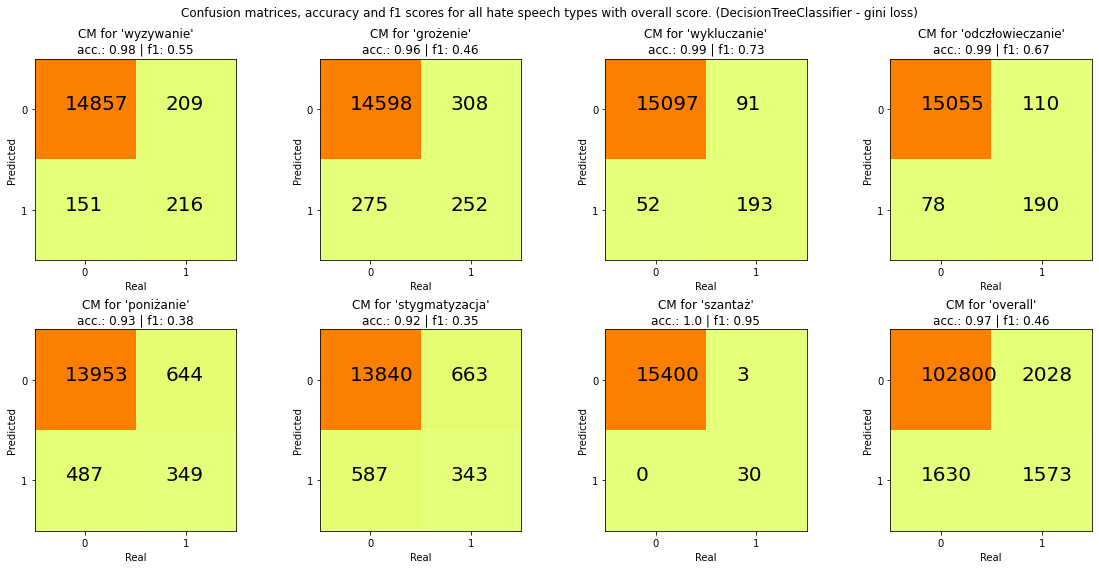

In [13]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(DecisionTreeClassifier - gini loss)'
confusion_matrices_plot(clf_scores, title=title, save_file='charts/simple_ml_classifier/cms_DT_gini.png')

### DecisionTreeClassifier (criterion='entropy')

In [14]:
model_path = 'models/simple_ml/DT_entropy.pkl'
if not os.path.exists(model_path):
    clf = DecisionTreeClassifier(random_state=0, criterion='entropy', class_weight='balanced')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

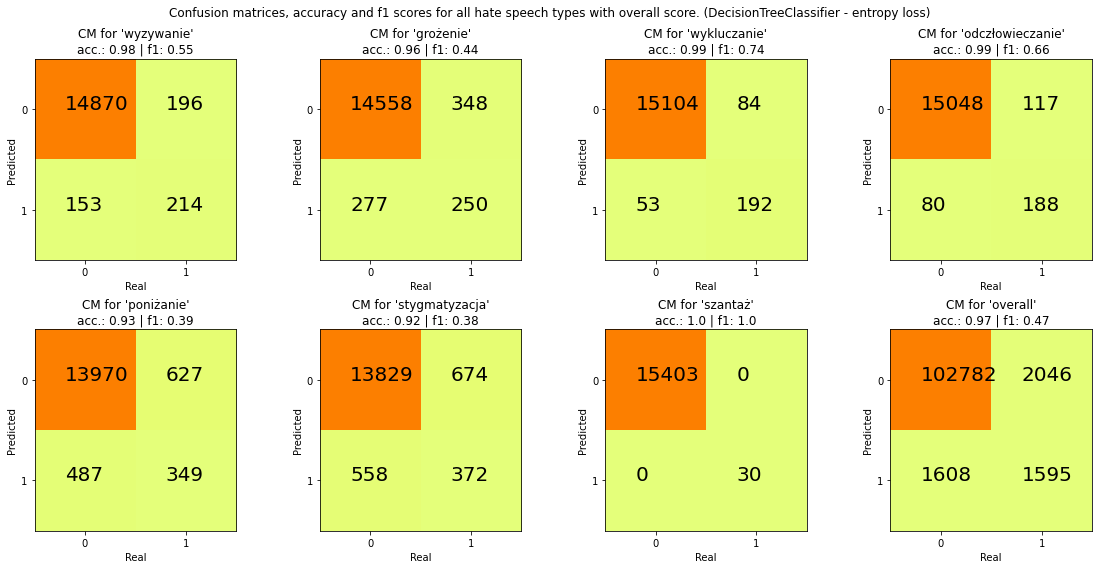

In [15]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(DecisionTreeClassifier - entropy loss)'
confusion_matrices_plot(clf_scores, title=title, save_file='charts/simple_ml_classifier/cms_DT_entropy.png')

### RandomForestClassifier (criterion='gini' | weight='balanced')

In [16]:
model_path = 'models/simple_ml/RF_gini_balanced.pkl'
if not os.path.exists(model_path):
    clf = RandomForestClassifier(random_state=0, criterion='gini', class_weight='balanced')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

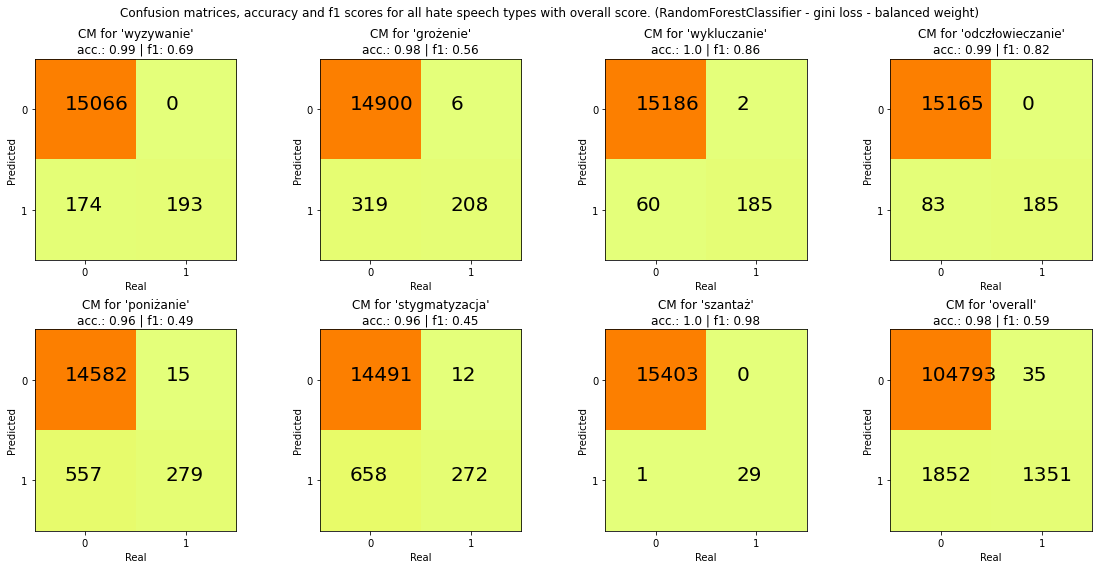

In [17]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(RandomForestClassifier - gini loss - balanced weight)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_RF_gini_balanced.png')

### RandomForestClassifier (criterion='gini' | weight='balanced_subsample')

In [18]:
model_path = 'models/simple_ml/RF_gini_balanced_subsample.pkl'
if not os.path.exists(model_path):
    clf = RandomForestClassifier(random_state=0, criterion='gini', class_weight='balanced_subsample')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    clf, clf_scores = load_classifier(model_path)

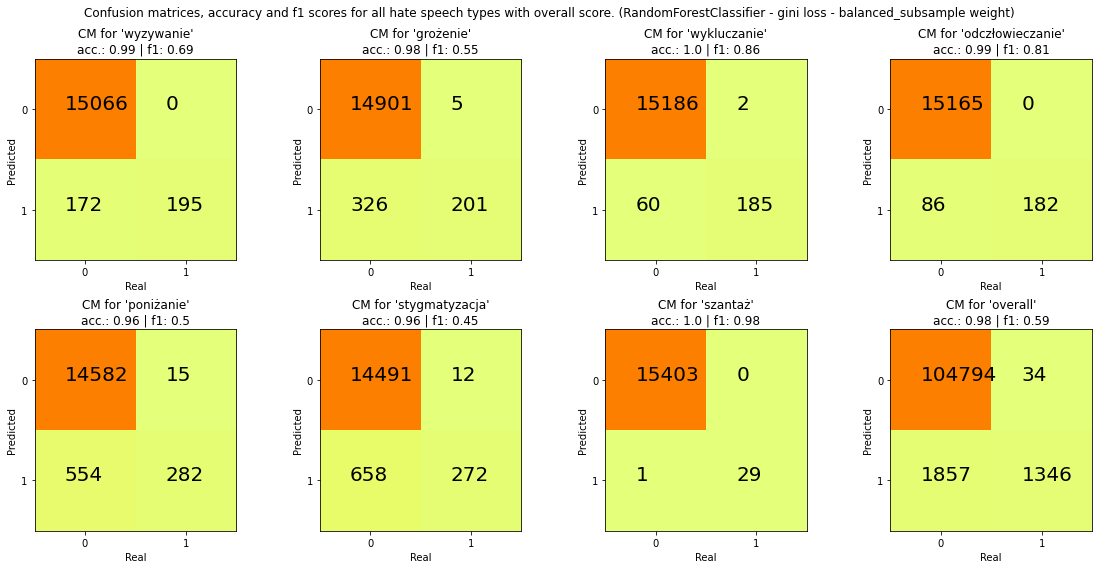

In [19]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(RandomForestClassifier - gini loss - balanced_subsample weight)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_RF_gini_balanced_subsample.png')

### RandomForestClassifier (criterion='entropy' | weight='balanced')

In [20]:
model_path = 'models/simple_ml/RF_entropy_balanced.pkl'
if not os.path.exists(model_path):
    clf = RandomForestClassifier(random_state=0, criterion='entropy', class_weight='balanced')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

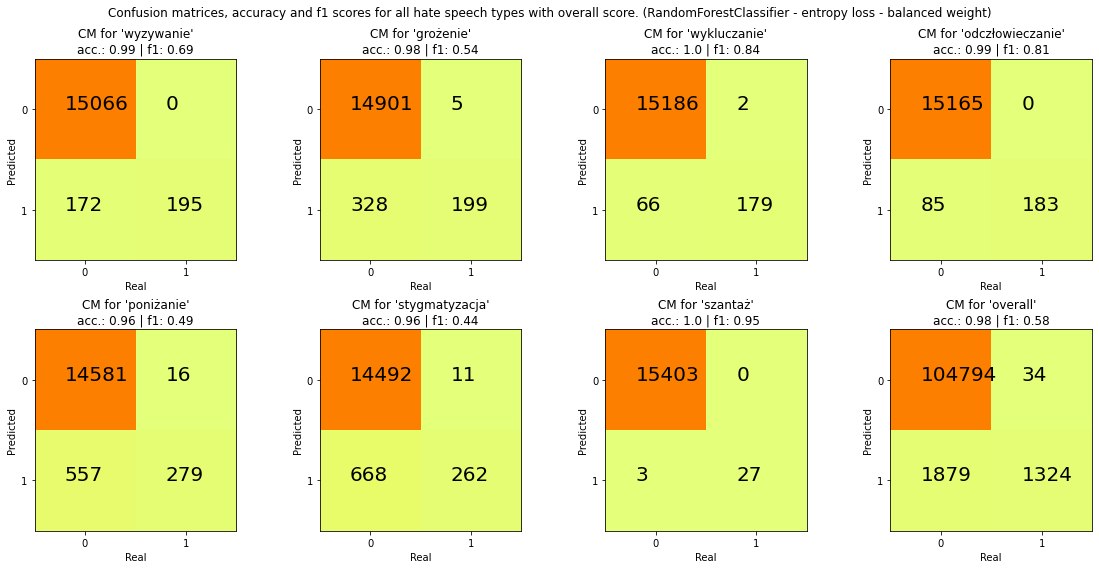

In [21]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(RandomForestClassifier - entropy loss - balanced weight)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_RF_entropy_balanced.png')

### RandomForestClassifier (criterion='entropy' | weight='balanced_subsample')

In [22]:
model_path = 'models/simple_ml/RF_entropy_balanced_subsample.pkl'
if not os.path.exists(model_path):
    clf = RandomForestClassifier(random_state=0, criterion='entropy', class_weight='balanced_subsample')
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

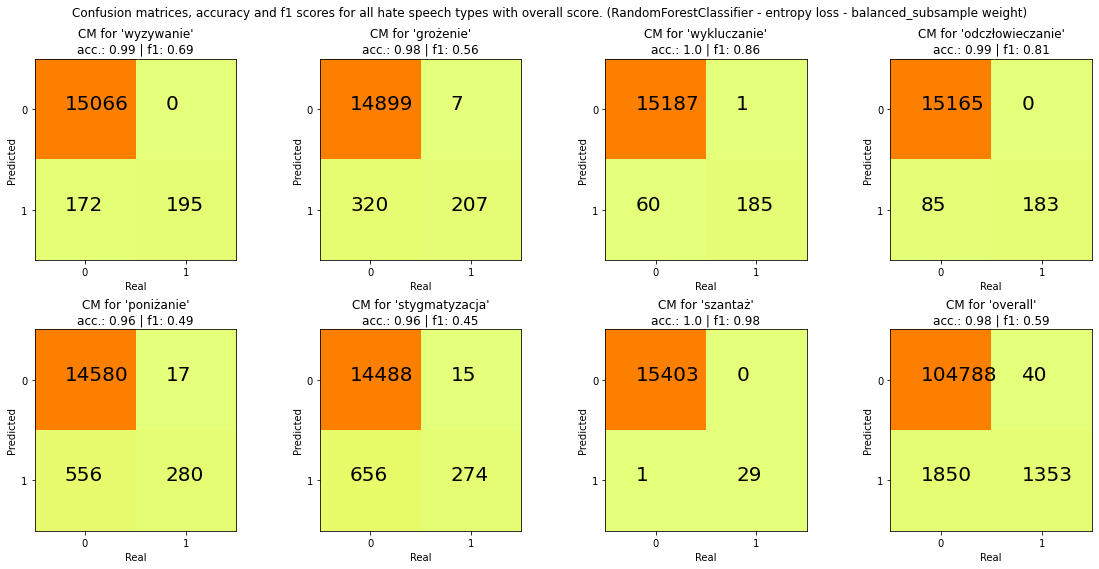

In [23]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(RandomForestClassifier - entropy loss - balanced_subsample weight)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_RF_entropy_balanced_subsample.png')

### SupportVectorClassifier (C=1.0 | kernel='linear')

In [24]:
model_path = 'models/simple_ml/SV_linear_1_0.pkl'
if not os.path.exists(model_path):
    clf = OneVsRestClassifier(SVC(random_state=0, kernel='linear', C=1.0))
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

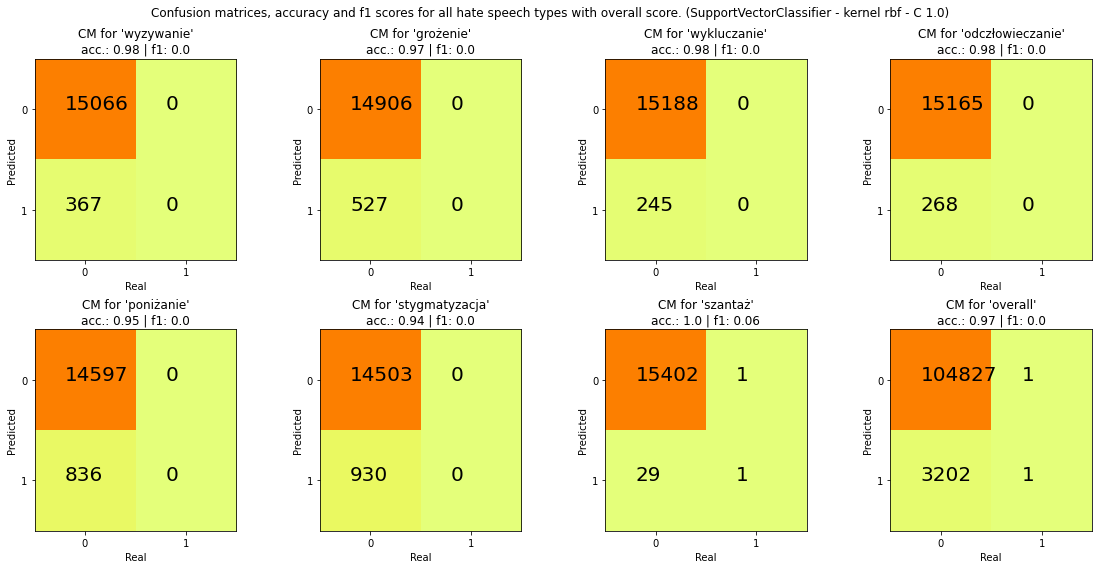

In [25]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(SupportVectorClassifier - kernel rbf - C 1.0)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_SV_linear_1_0.png')

### SupportVectorClassifier (C=1.0 | kernel='poly' | degree=3)

In [26]:
model_path = 'models/simple_ml/SV_poly_3_1_0.pkl'
if not os.path.exists(model_path):
    clf = OneVsRestClassifier(SVC(random_state=0, kernel='poly', degree=3, C=1.0))
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

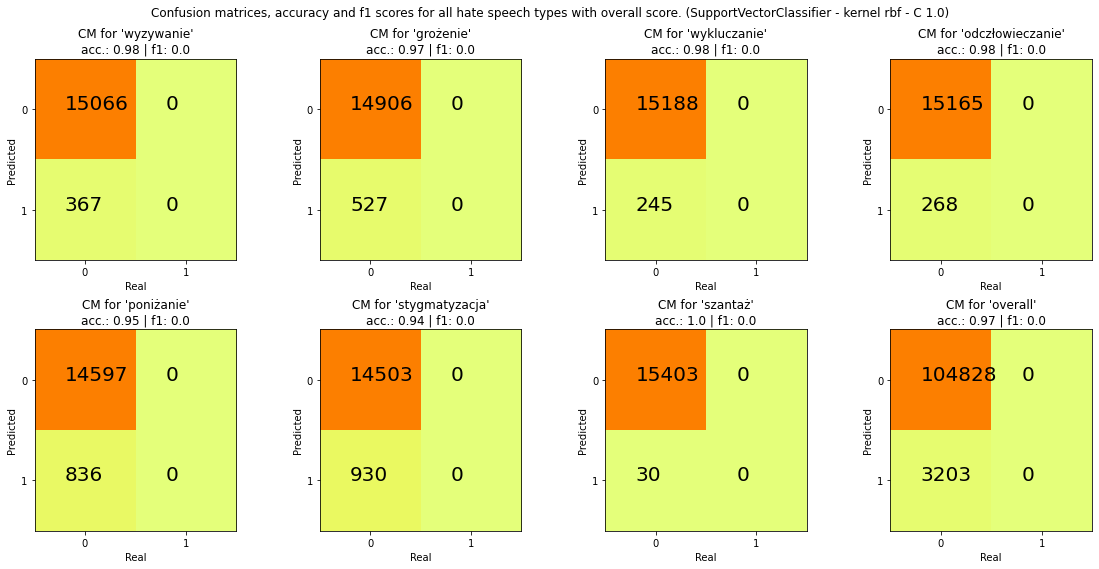

In [27]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(SupportVectorClassifier - kernel rbf - C 1.0)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_SV_poly_3_1_0.png')

### SupportVectorClassifier (C=1.0 | kernel='poly' | degree=5)

In [28]:
model_path = 'models/simple_ml/SV_poly_5_1_0.pkl'
if not os.path.exists(model_path):
    clf = OneVsRestClassifier(SVC(random_state=0, kernel='poly', degree=5, C=1.0))
    clf, clf_scores = classification(clf)
    save_classifier(clf, clf_scores, save_file=model_path)
    del clf
else:
    _, clf_scores = load_classifier(model_path)

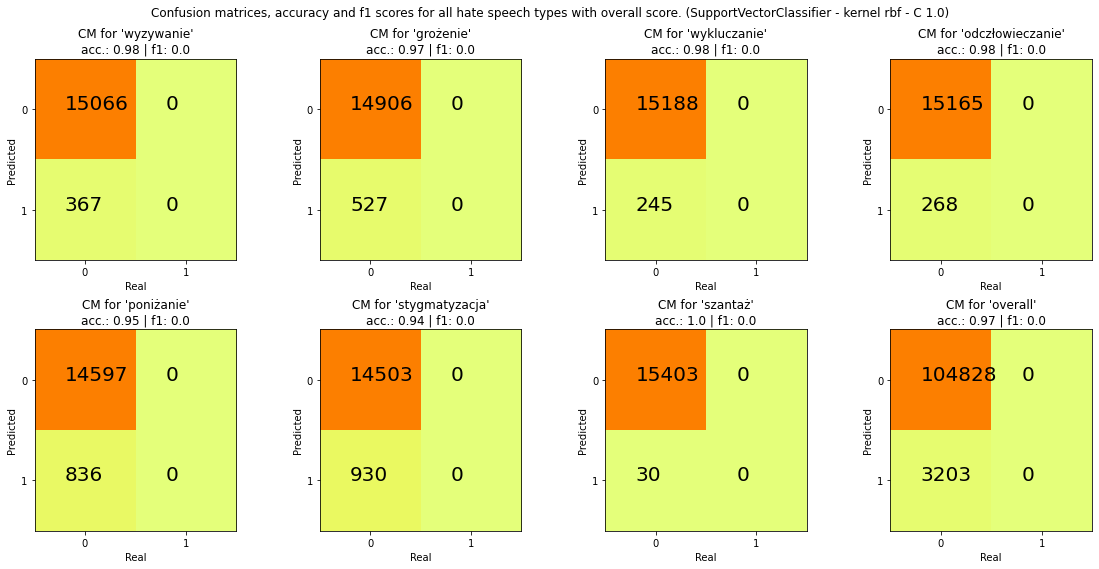

In [29]:
title = 'Confusion matrices, accuracy and f1 scores for all hate speech types with overall score. ' +\
        '(SupportVectorClassifier - kernel rbf - C 1.0)'
confusion_matrices_plot(clf_scores, title=title,
                        save_file='charts/simple_ml_classifier/cms_SV_poly_5_1_0.png')

### Best classifier determination

In [30]:
clf_names = sorted([f.replace('.pkl', '') for f in os.listdir('models/simple_ml')])
clf_names[:3]

['DT_entropy', 'DT_gini', 'RF_entropy_balanced']

In [31]:
scores = list([])
for file in sorted(os.listdir('models/simple_ml')):
    _, clf_scores = load_classifier(f'models/simple_ml/{file}')
    
    scores.append(clf_scores)

In [32]:
models_desc = ['_'.join(s[:3] for s in n.split('_')) for n in clf_names]
models_desc[:3]

['DT_ent', 'DT_gin', 'RF_ent_bal']

In [33]:
def models_quality_plot(scores, names, title='Models quality analysis.', save_file=None):
    fig, ax = plt.subplots(2, 4, figsize=(16, 10))
    positions = list([tuple((i, j)) for i in range(2) for j in range(4)])

    for i, (p, ht, fht) in enumerate(zip(positions, HATE_TYPES + ['overall'], FULL_HATE_TYPES + ['overall'])):
        x_line = np.arange(len(names))
        y_line_acc = [accuracy_cm(s[ht]) for s in scores]
        y_line_f1 = [f1_cm(s[ht]) for s in scores]
        
        ax[p[0]][p[1]].set_title(f'For \'{fht}\'')
        ax[p[0]][p[1]].set_ylabel('Score')
        ax[p[0]][p[1]].set_xlabel('Model')
        ax[p[0]][p[1]].set_xticks(x_line)
        ax[p[0]][p[1]].set_xticklabels(names, rotation='90')
        
        w = 0.4
        ax[p[0]][p[1]].bar(x_line - w/2, y_line_acc, label='accuracy', width = w)
        ax[p[0]][p[1]].bar(x_line + w/2, y_line_f1, label='f1', width = w)
        
    h, l = ax[0][0].get_legend_handles_labels()
    fig.legend(h, l, loc='upper right')
    
    fig.suptitle(title)

    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
    plt.show()

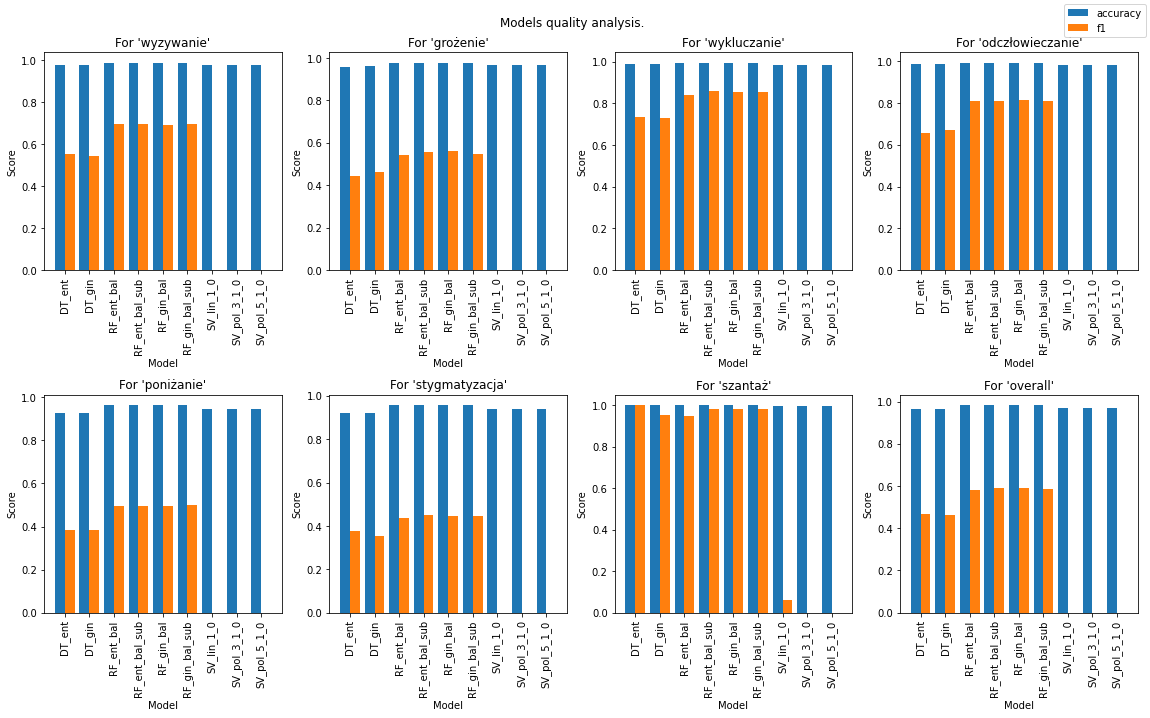

In [34]:
models_quality_plot(scores, models_desc, save_file='charts/simple_ml_classifier/model_acc_f1.png')

In [35]:
best_scores, best_models = list([]), list([])
for hate_type in HATE_TYPES + ['overall']:
    f1_s = np.array([f1_cm(sc[hate_type]) for sc in scores])
    
    best_scores.append(np.max(f1_s))
    best_models.append(clf_names[np.argmax(f1_s)])
best_scores = np.array(best_scores)
best_models = np.array(best_models)

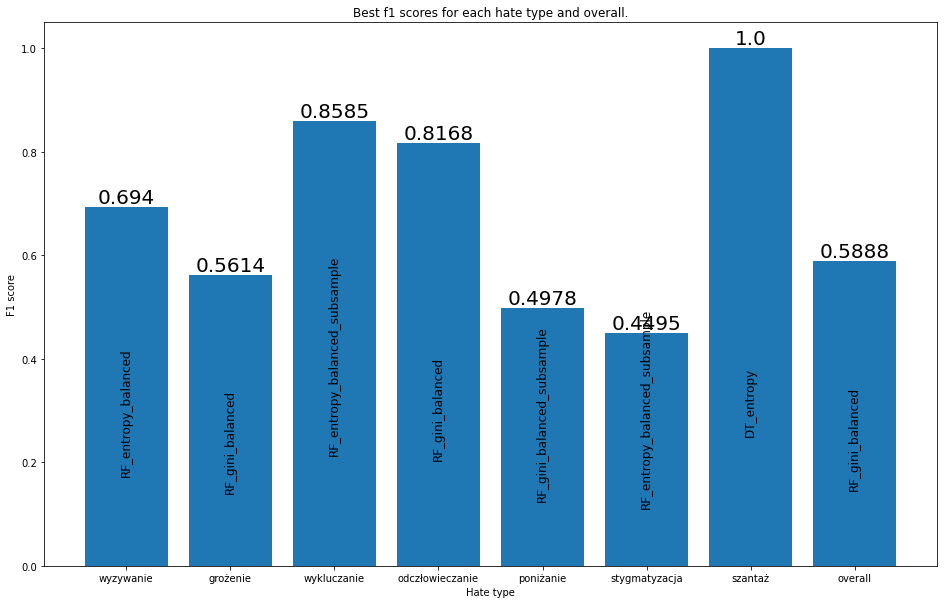

In [36]:
plt.figure(figsize=(16, 10))
x_labels = FULL_HATE_TYPES + ['overall']
bars = plt.bar(range(len(x_labels)), best_scores)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels)

plt.title('Best f1 scores for each hate type and overall.')
plt.xlabel('Hate type')
plt.ylabel('F1 score')

def autolabel(rects):
    for idx,rect in enumerate(bars):
        plt.text(rect.get_x() + rect.get_width()/2., rect.get_height(),
                 np.round(best_scores[idx], 4), ha='center', va='bottom', size=20)
        plt.text(rect.get_x() + rect.get_width()/2., 0.25*rect.get_height(),
                 best_models[idx], ha='center', va='bottom', rotation=90, size=12)
autolabel(bars)

plt.savefig('charts/simple_ml_classifier/best_models.png')
plt.show()

Judging by the above two analyses the best simple ML classifier is **RandomForest with gini loss and balanced subsample weights**.

In [37]:
best_clf, _ = load_classifier('models/simple_ml/RF_gini_balanced_subsample.pkl')

## Classifier tests

**Polish stopwords**

In [38]:
with open('data/other/polish_stopwords.txt', 'r') as f:
    polish_stopwords = f.read().split('\n')[:-1]
polish_stopwords[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

**Polish hyphenation model**

In [39]:
'pl_PL' in pyphen.LANGUAGES

True

In [40]:
dic = pyphen.Pyphen(lang='pl_PL')

### Lemmatize function

In [41]:
morf = morfeusz2.Morfeusz()

In [42]:
def lemmatize_text(text):
    analysis = morf.analyse(text.replace('#', ''))
    lemmas = list([])
    
    i, j, interp = analysis[0]
    last_ij, last_lemma = (i, j), interp[1].split(':')[0].lower()
    lemmas.append(last_lemma)
    
    for i, j, interp in analysis[1:]:
        lemma = interp[1].split(':')[0].lower()
        if not (last_ij == (i, j) and last_lemma == lemma):
            lemmas.append(lemma)
        
        last_ij = (i, j)
        last_lemma = lemma
    
    lemm_text = ' '.join(lemmas)
    lemm_text = lemm_text.replace(' [ . . . ]', '')
    
    return lemm_text

### Hateful phrases

In [43]:
lemm_files = ['lemm_wyz.txt', 'lemm_groz.txt', 'lemm_wyk.txt', 'lemm_odcz.txt', 'lemm_pon.txt',
              'lemm_styg.txt', 'lemm_szan.txt']
syn_files = ['syn_wyz.txt', 'syn_groz.txt', 'syn_wyk.txt', 'syn_odcz.txt', 'syn_pon.txt',
             'syn_styg.txt', 'syn_szan.txt']

In [44]:
lemmatized_phrases, synonymic_phrases = list([]), list([])

for lemm_file in lemm_files:
    with open(f'data/hateful_phrases/{lemm_file}', 'r') as f:
        lemmatized_phrases.append(f.read().split('\n')[:-1])

for syn_file in syn_files:
    with open(f'data/hateful_phrases/{syn_file}', 'r') as f:
        synonymic_phrases.append(f.read().split('\n')[:-1])

In [45]:
lemmatized_phrases[0][:5]

['komuch',
 'gonić komuch',
 'kwaśniewski idiota',
 'pojebać kto ktoś być',
 'polityk kłapać dziób']

In [46]:
synonymic_phrases[0][:5]

['pojebać',
 'czuj czuja czuć ?',
 'prezydent wart warta wart szacunek',
 'ch . m miasto morze męski metr . wiek wielki wiersz wieś wyspa . d dawny dom dzień .',
 'chuj dupa']

### Hateful topics

In [47]:
topic_files = ['lda_wyz.pkl', 'lda_groz.pkl', 'lda_wyk.pkl', 'lda_odcz.pkl', 'lda_pon.pkl',
               'lda_styg.pkl', 'lda_szan.pkl', 'lda_vulg.pkl']
N_WORDS = 10

In [48]:
def lda_topics(lda_model, lda_cv, n_words):
    words = lda_cv.get_feature_names()
    
    topics = list([' '.join([words[i] for i in topic.argsort()[:-n_words - 1:-1]])
                   for topic in lda_model.components_])
    
    return topics

In [49]:
topics = list([])

for topic_file in topic_files:
    with open(f'models/lda/{topic_file}', 'rb') as f:
        lda_model, cv = pickle.load(f)

        topics.append(lda_topics(lda_model, cv, n_words=N_WORDS))

In [50]:
topics[0][:5]

['sąd zjebać komuch sędzia mafijny gnida okupancki złodziejski partyjny bandycki',
 'pisa pis idiota ruski lato rok baran kundel barani polska',
 'polski sąd wypierdalać kurwa jaka naczelny won polskie szmatławiec wygląd',
 'sąd kurwa pajac złodziej chory morda żydowski pierdolić skurwysyn strzelać',
 'sąd debil komunistyczny sędzia wart kretyn prezydent faszysta jebać jarka']

### PAC (Phrase Appearance Coefficient) calculation

In [51]:
def calculate_PAC(text, phrase, lemmatized=False, stopwords=[]):
    
    t = text if lemmatized else lemmatize_text(text)
    p = phrase if lemmatized else lemmatize_text(phrase)
    
    t_words = list(filter(lambda x: x not in stopwords, t.split(' ')))
    p_words = list(filter(lambda x: x not in stopwords, p.split(' ')))
    
    assert (len(t_words) > 0), 'The examined text must have at least one non-stopword word!'
    
    if len(p_words) > 1:
        occurences = list([[i for i, x in enumerate(t_words) if x == p_w] for p_w in p_words])
        occurences = list([o for o in occurences if len(o) > 0])

        orders = list(itertools.product(*occurences))
        order_pairs_list = list([[tuple((o[i], o[i+1])) for i, oi in enumerate(o[:-1])] for o in orders])

        coeffs = list([sum([1. if op[0]<op[1] else -1. for op in ops])/(len(p_words) - 1)
                       for ops in order_pairs_list])

        return (np.min(coeffs), np.mean(coeffs), np.max(coeffs))
    elif len(p_words) == 1:
        return (1., 1., 1.) if p_words[0] in t_words else (0., 0., 0.)
    else:
        return (0., 0., 0.)

### Sentiment and text counts

In [52]:
def text_sentiment(text):
    
    # detect and delete invalid characters first
    t = text
    invalid = set()
    for i, ch in enumerate(t):
        try:
            Text(f"Char: {ch}").words
        except:
            invalid.add(ch)
    for ch in invalid:
        t = t.replace(ch, '')
    
    t = Text(t)
    sents = list([])
    for w in t.words:
        try:
            s = w.polarity
        except ValueError:
            s = 0
        sents.append(s)
    sents = np.array(sents)
    
    return np.size(sents[sents==-1]), np.size(sents[sents==0]), np.size(sents[sents==1])

def text_numbers(text):
    num_chars = len(text.replace(' ', ''))
    num_syllables = sum([len(dic.inserted(word).split('-')) for word in text.split(' ')])
    num_words = len(text.split(' '))
    num_unique_words = len(set(text.lower().split(' ')))
    
    return num_chars, num_syllables, num_words, num_unique_words

In [53]:
def calculate_classes_PACs(tweet_text):
    scores = dict({})
        
    for hate_type, l_phrases, s_phrases in zip(HATE_TYPES, lemmatized_phrases, synonymic_phrases):
        sc_min, sc_mean, sc_max = list([]), list([]), list([])

        for l_phrase in l_phrases:
            mn, mean, mx = calculate_PAC(tweet_text, l_phrase, lemmatized=True, stopwords=polish_stopwords)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        for s_phrase in s_phrases:
            mn, mean, mx = calculate_PAC(tweet_text, s_phrase, lemmatized=True, stopwords=polish_stopwords)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        scores[f'{hate_type}_min'] = np.min(sc_min)
        scores[f'{hate_type}_mean'] = np.mean(sc_mean)
        scores[f'{hate_type}_max'] = np.max(sc_max)
        del sc_min, sc_mean, sc_max
    
    return np.array(list(scores.values()))

def calculate_other_scores(tweet_text):
    scores = dict({})
    
    scores['neg'], scores['neu'], scores['pos'] = text_sentiment(tweet_text)
    scores['chars'], scores['sylls'], scores['words'], scores['u_words'] = text_numbers(tweet_text)
    scores['l_chars'], scores['l_sylls'], scores['l_words'], scores['l_u_words'] = text_numbers(lemmatize_text(tweet_text))
    
    return np.array(list(scores.values()))

def calculate_classes_topic_PACs(tweet_text):
    scores = dict({})
        
    for hate_type, topic in zip(HATE_TYPES + ['vulg'], topics):
        sc_min, sc_mean, sc_max = list([]), list([]), list([])

        for t in topic:
            mn, mean, mx = calculate_PAC(tweet_text, t, lemmatized=True, stopwords=polish_stopwords)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        scores[f'{hate_type}_min'] = np.min(sc_min)
        scores[f'{hate_type}_mean'] = np.mean(sc_mean)
        scores[f'{hate_type}_max'] = np.max(sc_max)
        del sc_min, sc_mean, sc_max
    
    return np.array(list(scores.values()))

def predict(scores, long_names=True):
    pred = best_clf.predict(np.array(scores)).flatten()
    
    if long_names:
        return dict(zip(FULL_HATE_TYPES, pred))
    else:
        return dict(zip(HATE_TYPES, pred))

### Test 1

In [54]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
test_text1

'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'

In [55]:
test_text1_lemmatized = lemmatize_text(test_text1)
test_text1_lemmatized

'nie on nie . po prosty skorumpować zgniły zatruć przez ty i twój twoi twoja twoje twój koleś sąd , który swój swoje zawsze wybronić'

In [56]:
scores11 = calculate_classes_PACs(test_text1_lemmatized)
scores12 = calculate_other_scores(test_text1)
scores13 = calculate_classes_topic_PACs(test_text1_lemmatized)

In [57]:
predict(np.concatenate([scores11, scores12, scores13]).reshape(1, -1))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'stygmatyzacja': 1.0.

### Test 2

In [58]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
test_text2

'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'

In [59]:
test_text2_lemmatized = lemmatize_text(test_text2)
test_text2_lemmatized

'ten to nie on nie sąd , ten to człowiek lud człowiek , sędzia , zdrajca barbarzyńca barbarzyniec w toga z mafijny organizacja zdradziecko zbrodniczy który muszy musieć musić musza zostać wyeliminować'

In [60]:
scores21 = calculate_classes_PACs(test_text2_lemmatized)
scores22 = calculate_other_scores(test_text2)
scores23 = calculate_classes_topic_PACs(test_text2_lemmatized)

In [61]:
predict(np.concatenate([scores21, scores22, scores23]).reshape(1, -1))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically shoul be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as 1.0.

### Test 3

In [62]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
test_text3

'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '

In [63]:
test_text3_lemmatized = lemmatize_text(test_text3)
test_text3_lemmatized

'przed repolonizacja teren wyczyścić ! raz , dwa ! nie on nie patrzeć na bok ! sąd sąd , ale media medium muszy musieć musić musza bycie być nasz nasze media medium'

In [64]:
scores31 = calculate_classes_PACs(test_text3_lemmatized)
scores32 = calculate_other_scores(test_text3)
scores33 = calculate_classes_topic_PACs(test_text3_lemmatized)

In [65]:
predict(np.concatenate([scores31, scores32, scores33]).reshape(1, -1))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'grożenie': 1.0.